## Спринт 1: задача GloVe
Освоено создание векторов без расчёта значений имён собственных

Получен один набор векторов:
- по co-occurance матрице слов из текстов Роулинг
- без имён собственных
- на 26% `librusec_fb2.plain`
- с параметрами `x-max: 10`, `iter: 30`, `vector-size: 300`

### Вкладка вычислений

In [1]:
from tg.grammar_ru import *
import os
import pandas as pd
import numpy as np
from yo_fluq_ds import *
import subprocess
import ipywidgets as widgets


FOLDER = Loc.data_cache_path/'Rowling'
os.makedirs(FOLDER,exist_ok=True)
db = DataBundle.load(FOLDER/'bundle.zip')
GLOVE = FOLDER/'glove'
vectors_file = GLOVE/'output.txt'

In [2]:
nyms = pd.read_parquet(Loc.data_cache_path/'nyms.parquet')
nyms.word = nyms.word.str.replace('ё','е')
nyms.nym = nyms.nym.str.replace('ё','е')
nyms

,index,word,nym_type,occurence,nym
0,1,е,hyper,0,буква
1,2,е,syn,1,надо же
2,2,е,syn,1,елки зеленые
3,2,е,syn,1,елки-моталки
4,2,е,syn,1,елки-палки
...,...,...,...,...,...
482844,732899,Кустиков,hyper,0,фамилия
482845,732901,Рычажков,hyper,0,фамилия
482846,732904,Шнурков,hyper,0,фамилия
482847,732911,ложник,syn,0,ружейник


In [3]:
simple_filter = lambda x: ~(x.str.contains(' ') | x.str.contains('-'))
simple_nyms = nyms[simple_filter(nyms.nym) & simple_filter(nyms.word)]
synonyms_little = simple_nyms[simple_nyms.nym_type == 'syn']
word_1 = synonyms_little.word.unique()
word_2 = synonyms_little.nym.unique()
synonyms_little = synonyms_little.set_index(['word','nym'])
synonyms_little[100:120]

index nym_type  occurence
word    nym                                     
мальчик пацаненок        127      syn          0
        подросток        127      syn          0
        шкет             127      syn          0
        шпингалет        127      syn          0
химия   химикат          135      syn          0
        перманент        136      syn          0
агент   представитель    146      syn          0
        сотрудник        146      syn          0
        разведчик        147      syn          0
        шпион            147      syn          0
        фактор           149      syn          1
день    свет             151      syn          0
        сутки            152      syn          0
        праздник         153      syn          0
        юбилей           153      syn          0
        годовщина        153      syn          0
        час              154      syn          0
        момент           154      syn          0
деньги  денежки          162      syn          0
        денежка          162      syn          0

In [4]:
from tg.grammar_ru.common import sample_table
from jordan_lib.preprocessing import _parse_words, _produce_stems

def normlize_magnificent(word_list):
    reliable = [
        'DictionaryAnalyzer',
        'DictionaryAnalyzer-KnownPrefixAnalyzer'
    ]
    
    def produce_ndf(df):
        ndf_full = _parse_words(Query.en(df.word).feed(fluq.with_progress_bar()))
        df = _produce_stems(df)
        ndf_0 = ndf_full
        ndf_0 = ndf_0.merge(df.set_index('word'), left_on='word', right_index=True)
        return ndf_0
    
    word_df = pd.DataFrame(data = word_list, columns = ['word'])
    ndf_1 = produce_ndf(word_df)
    ndf_rel = ndf_1.loc[ndf_1.method.isin(reliable)]
    df = ndf_rel.drop_duplicates(['word','nf'])
    df = df.merge(df.groupby('word').size().to_frame('alternatives'), left_on='word', right_index=True)
    df = df.feed(fluq.add_ordering_column('word',('scores', False), 'nf_scores_order'))
    nf_1 = df.loc[df.nf_scores_order==0][['word','nf']].assign(nf_rule='pymorphy')
    ndf_2 = ndf_1.loc[~ndf_1.word.isin(nf_1.word)]
    mdf = ndf_2.drop_duplicates(['word','stem'])
    sdf = mdf.feed(fluq.add_ordering_column('stem',('scores',False),'word_in_stem_order'))
    sdf = sdf.loc[sdf.word_in_stem_order==0]
    sdf = sdf.drop('nf',axis=1).rename(columns=dict(word='nf')).set_index('stem')[['nf']]
    rdf = mdf[['word','stem']].merge(sdf, left_on='stem', right_index=True)
    nf_2 = pd.concat([nf_1, rdf[['word','nf']].assign(nf_rule='stem')])
    return pd.concat([nf_1[['word', 'nf']], nf_2[['word', 'nf']]]).reset_index(drop=True)
word_1_norms = normlize_magnificent(word_1)
word_2_norms = normlize_magnificent(word_2)

  0%|          | 0/103601 [00:00<?, ?it/s]

  0%|          | 0/103601 [00:00<?, ?it/s]

  0%|          | 0/110213 [00:00<?, ?it/s]

  0%|          | 0/110213 [00:00<?, ?it/s]

In [5]:
from jordan_lib.amenities import compute_all_scores_partitioned, merge_2

def compute_voc(path):
    gdf = pd.read_csv(path, sep=' ',header=None).set_index(0)
    gdf = gdf.reset_index(drop=True).iloc[:-1]
    gdf.columns=list(range(gdf.shape[1]))
    gdf.index.name='index'
    
    frst = db.nfs[db.nfs.nf.isin(word_1_norms.nf)]
    scnd = db.nfs[db.nfs.nf.isin(word_2_norms.nf)]
    pdf = (
        compute_all_scores_partitioned(gdf, frst.index.unique(), scnd.index.unique())
        .feed(fluq.with_progress_bar())
        .select(lambda z: z.loc[z.order<100])
        .feed(lambda z: pd.concat(list(z)))
    )
    pdf = merge_2(pdf, db.nfs, 'index')
    return pdf

voc_df = compute_voc(vectors_file)

  0%|          | 0/1371 [00:00<?, ?it/s]

In [6]:
synonyms_little['is_syn'] = 1

In [7]:
def compute_syn_plot(voc_5):
    qdf = voc_5.merge(synonyms_little.is_syn, left_on=('nf_1', 'nf_2'), right_index=True, how='left')
    qdf.is_syn=qdf.is_syn.fillna(0)
    qdf = qdf.sort_values('order')
    ss = []
    for w in qdf.nf_1.unique():
        qqdf = qdf.loc[qdf.nf_1==w].set_index('order').is_syn
        qqdf = qqdf[~qqdf.index.duplicated()]
        ss.append(qqdf.iloc[1:])
    return pd.concat(ss,axis=1).mean(axis=1)

p = compute_syn_plot(voc_df)

<AxesSubplot:xlabel='order'>

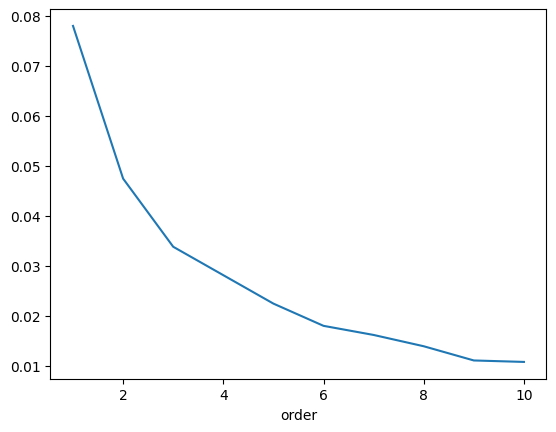

In [8]:
p.iloc[:10].plot()

In [9]:
p

order
1     0.078018
2     0.047438
3     0.033791
4     0.028098
5     0.022405
        ...   
95    0.001095
96    0.000657
97    0.000949
98    0.001241
99    0.000949
Length: 99, dtype: float64